# Spotify Global Chart Analysis

### Load Libraries and Dataset

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

sns.set_palette('RdBu_r')

In [3]:
df = pd.read_csv('charts.csv')
df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


## Data Cleaning and Preprocessing

In [4]:
# relevant columns
rel_cols = ['title', 'rank', 'date', 'artist', 'region', 'chart', 'streams']

In [5]:
raw_data = pd.read_csv('charts.csv',usecols=rel_cols)

In [6]:
df = raw_data.copy()
df.head()

,title,rank,date,artist,region,chart,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,top200,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,top200,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,top200,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,top200,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,top200,153956.0


In [87]:
df['region'].unique() # to check uniques values

array(['Argentina', 'Australia', 'Brazil', 'Austria', 'Belgium',
       'Colombia', 'Bolivia', 'Denmark', 'Bulgaria', 'Canada', 'Chile',
       'Costa Rica', 'Czech Republic', 'Finland', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Estonia', 'France', 'Germany', 'Global',
       'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Hungary',
       'Iceland', 'Indonesia', 'Ireland', 'Italy', 'Japan', 'Latvia',
       'Lithuania', 'Malaysia', 'Luxembourg', 'Mexico', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Panama', 'Paraguay', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Singapore', 'Spain',
       'Slovakia', 'Sweden', 'Taiwan', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States', 'Uruguay', 'Thailand',
       'Andorra', 'Romania', 'Vietnam', 'Egypt', 'India', 'Israel',
       'Morocco', 'Saudi Arabia', 'South Africa', 'United Arab Emirates',
       'Russia', 'Ukraine', 'South Korea'], dtype=object)

In [58]:
df.isnull().sum()

title           11
rank             0
date             0
artist          18
region           0
chart            0
streams    5851610
year             0
month            0
day              0
dtype: int64

In [10]:
df['title'].fillna(df['title'].mode()[0], inplace=True)
df['artist'].fillna(df['artist'].mode()[0], inplace=True)

In [11]:
df.isnull().sum()

title            0
rank             0
date             0
artist           0
region           0
chart            0
streams    5851610
dtype: int64

In [8]:
def detect_outliers_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Identify outliers in the 'streams' column
outliers = detect_outliers_IQR(df['streams'])

# Handle outliers: Here we can choose to remove or cap them
# For this example, we'll cap the outliers to the upper and lower bounds

# Calculate the lower and upper bounds
Q1 = df['streams'].quantile(0.25)
Q3 = df['streams'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers
df['streams'] = np.where(df['streams'] > upper_bound, upper_bound,
                         np.where(df['streams'] < lower_bound, lower_bound, df['streams']))

# Verify that outliers are addressed
print("\nSummary statistics for 'streams' column after addressing outliers:")
print(df['streams'].describe())

count    2.032190e+07
mean     5.526131e+04
std      2.095872e+05
min      1.001000e+03
25%      3.546000e+03
50%      9.565000e+03
75%      3.540900e+04
max      1.974970e+07
Name: streams, dtype: float64

Summary statistics for 'streams' column after addressing outliers:
count    2.032190e+07
mean     2.376103e+04
std      2.755379e+04
min      1.001000e+03
25%      3.546000e+03
50%      9.565000e+03
75%      3.540900e+04
max      8.320350e+04
Name: streams, dtype: float64


In [9]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extracting year, month, and day from the 'date' column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day



In [10]:
df.head()

,title,rank,date,artist,region,chart,streams,year,month,day
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,top200,83203.5,2017,1,1
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,top200,83203.5,2017,1,1
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,top200,83203.5,2017,1,1
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,top200,83203.5,2017,1,1
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,top200,83203.5,2017,1,1


## EDA

In [72]:
df.shape

(26173514, 10)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 10 columns):
 #   Column   Dtype         
---  ------   -----         
 0   title    object        
 1   rank     int64         
 2   date     datetime64[ns]
 3   artist   object        
 4   region   object        
 5   chart    object        
 6   streams  float64       
 7   year     int64         
 8   month    int64         
 9   day      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.0+ GB


In [23]:
df.describe()

,rank,streams,year,month,day
count,2.617351e+07,2.032190e+07,2.617351e+07,2.617351e+07,2.617351e+07
mean,8.092314e+01,2.376103e+04,2.019135e+03,6.523776e+00,1.574078e+01
std,5.918601e+01,2.755379e+04,1.390380e+00,3.413493e+00,8.792204e+00
min,1.000000e+00,1.001000e+03,2.017000e+03,1.000000e+00,1.000000e+00
25%,2.900000e+01,3.546000e+03,2.018000e+03,4.000000e+00,8.000000e+00
50%,6.700000e+01,9.565000e+03,2.019000e+03,7.000000e+00,1.600000e+01
75%,1.310000e+02,3.540900e+04,2.020000e+03,9.000000e+00,2.300000e+01
max,2.000000e+02,8.320350e+04,2.021000e+03,1.200000e+01,3.100000e+01


In [32]:
# Measures of central tendency and dispersion for 'streams'
print(f"Mean: {df['streams'].mean()}")
print(f"Median: {df['streams'].median()}")
print(f"Mode: {df['streams'].mode()[0]}")
print(f"Standard Deviation: {df['streams'].std()}")
print(f"Variance: {df['streams'].var()}")
print(f"Range: {df['streams'].max() - df['streams'].min()}")


Mean: 23761.02901108577
Median: 9565.0
Mode: 83203.5
Standard Deviation: 27553.79221615712
Variance: 759211465.4911606
Range: 82202.5


In [25]:
# Correlation analysis between numerical variables
correlation_matrix = df.corr(numeric_only=True)
print("\nCorrelation matrix:")
print(correlation_matrix)


Correlation matrix:
             rank   streams      year     month       day
rank     1.000000 -0.240289  0.023802  0.001019  0.000340
streams -0.240289  1.000000  0.039986  0.017068  0.002604
year     0.023802  0.039986  1.000000 -0.036468  0.000236
month    0.001019  0.017068 -0.036468  1.000000  0.009732
day      0.000340  0.002604  0.000236  0.009732  1.000000


In [26]:
# Group by 'region' and calculate mean streams
region_group = df.groupby('region')['streams'].mean()
print("\nMean streams by region:")
print(region_group)


Mean streams by region:
region
Andorra                          NaN
Argentina               42503.985764
Australia               47610.238533
Austria                  7420.155444
Belgium                 10822.340845
                            ...     
United Arab Emirates     2147.129325
United Kingdom          68087.002710
United States           83203.500000
Uruguay                  3768.295815
Vietnam                  5685.024107
Name: streams, Length: 70, dtype: float64


In [27]:
chart_group = df.groupby('chart')['streams'].sum()
print("\nSum of streams by chart:")
print(chart_group)


Sum of streams by chart:
chart
top200     4.828694e+11
viral50    0.000000e+00
Name: streams, dtype: float64


In [28]:
# Explore the relationship between 'artist' and 'streams'
artist_group = df.groupby('artist')['streams'].agg(['mean', 'sum', 'count'])
print("\nStreams statistics by artist:")
print(artist_group.sort_values(by='sum', ascending=False).head())


Streams statistics by artist:
                       mean           sum   count
artist                                           
Ed Sheeran     22357.897304  8.183572e+09  366026
Billie Eilish  22599.516126  5.198047e+09  230007
Post Malone    26042.076683  5.120393e+09  196620
Ariana Grande  24966.248496  4.354189e+09  174403
Drake          27350.897105  4.289851e+09  156845


In [29]:
# Display top 5 regions by mean streams
top_regions = region_group.sort_values(ascending=False).head()
print("\nTop 5 regions by mean streams:")
print(top_regions)


Top 5 regions by mean streams:
region
United States    83203.500000
Global           83203.500000
Brazil           77694.470487
Mexico           74398.734082
Germany          70283.451711
Name: streams, dtype: float64


In [30]:
# Display top 5 charts by total streams
top_charts = chart_group.sort_values(ascending=False).head()
print("\nTop 5 charts by total streams:")
print(top_charts)



Top 5 charts by total streams:
chart
top200     4.828694e+11
viral50    0.000000e+00
Name: streams, dtype: float64


In [31]:
# Display top 5 artists by total streams
top_artists = artist_group.sort_values(by='sum', ascending=False).head()
print("\nTop 5 artists by total streams:")
print(top_artists)


Top 5 artists by total streams:
                       mean           sum   count
artist                                           
Ed Sheeran     22357.897304  8.183572e+09  366026
Billie Eilish  22599.516126  5.198047e+09  230007
Post Malone    26042.076683  5.120393e+09  196620
Ariana Grande  24966.248496  4.354189e+09  174403
Drake          27350.897105  4.289851e+09  156845


## Hypothesis Testing

In [69]:
# Hypothesis 1: t-test for mean difference between two specific regions (e.g., 'RegionA' and 'RegionB')
region_a = df[df['region'] == 'South Korea']['streams']
region_b = df[df['region'] == 'Peru']['streams']

# Perform t-test
t_stat, p_value = ttest_ind(region_a, region_b, nan_policy='omit')

print("Hypothesis 1: Mean number of streams between South Korea and Peru")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Check the result
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis.')
else:
    print("Fail to reject the null hypothesis.")

Hypothesis 1: Mean number of streams between Region A and Region B
t-statistic: -250.3295118986614
p-value: 0.0
Reject the null hypothesis.


In [45]:
# Hypothesis 2: Chi-square test for independence between chart entries and region
# Create a contingency table
contingency_table = pd.crosstab(df['chart'], df['region'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("\nHypothesis 2: Independence of chart entries and region")
print(f"Chi-square statistic: {chi2_stat}")
print(f"p-value: {p_val}")

# Check the result
if p_val < alpha:
    print("Reject the null hypothesis. ")
else:
    print("Fail to reject the null hypothesis.")



Hypothesis 2: Independence of chart entries and region
Chi-square statistic: 885575.4198018827
p-value: 0.0
Reject the null hypothesis. 


## Advanced Analysis

In [95]:
# Encode categorical features with limited memory usage
df_encoded = pd.get_dummies(df, columns=['title', 'artist', 'region', 'chart'], sparse=True)

# Select features and target variable
X = df_encoded.drop(columns=['streams', 'date'])
y = df_encoded['streams']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


KeyboardInterrupt: 

In [49]:
# Encode categorical features
df_encoded = pd.get_dummies(df, columns=['title', 'artist', 'region', 'chart'])

# Select features and target variable for classification
X = df_encoded.drop(columns=['region', 'date'])
y = df_encoded['region']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)


NameError: name 'df_encoded' is not defined

## Data Visualization

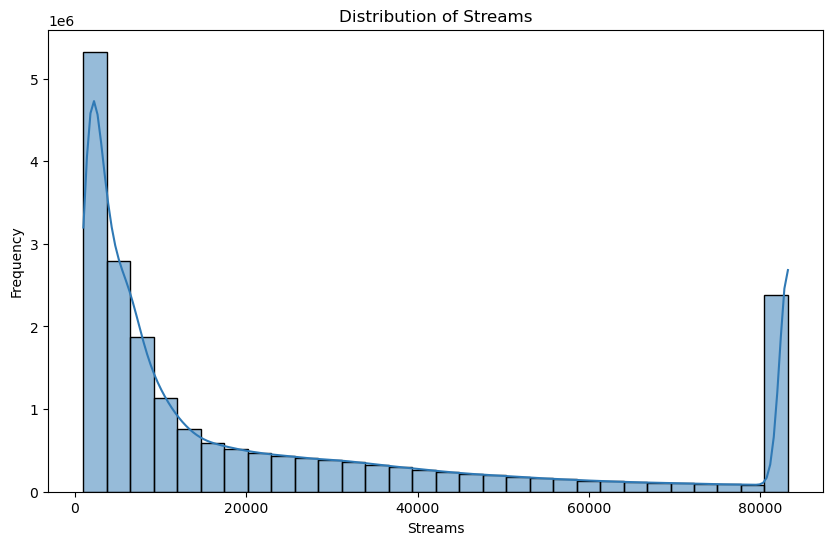

In [70]:
# Histogram for 'streams'
plt.figure(figsize=(10, 6))
sns.histplot(df['streams'], kde=True, bins=30)
plt.title('Distribution of Streams')
plt.xlabel('Streams')
plt.ylabel('Frequency')
plt.show()

Result:The data suggests that most streams have a frequency of less than 20,000.
There is a sharp drop off in the number of streams observed at higher frequencies.

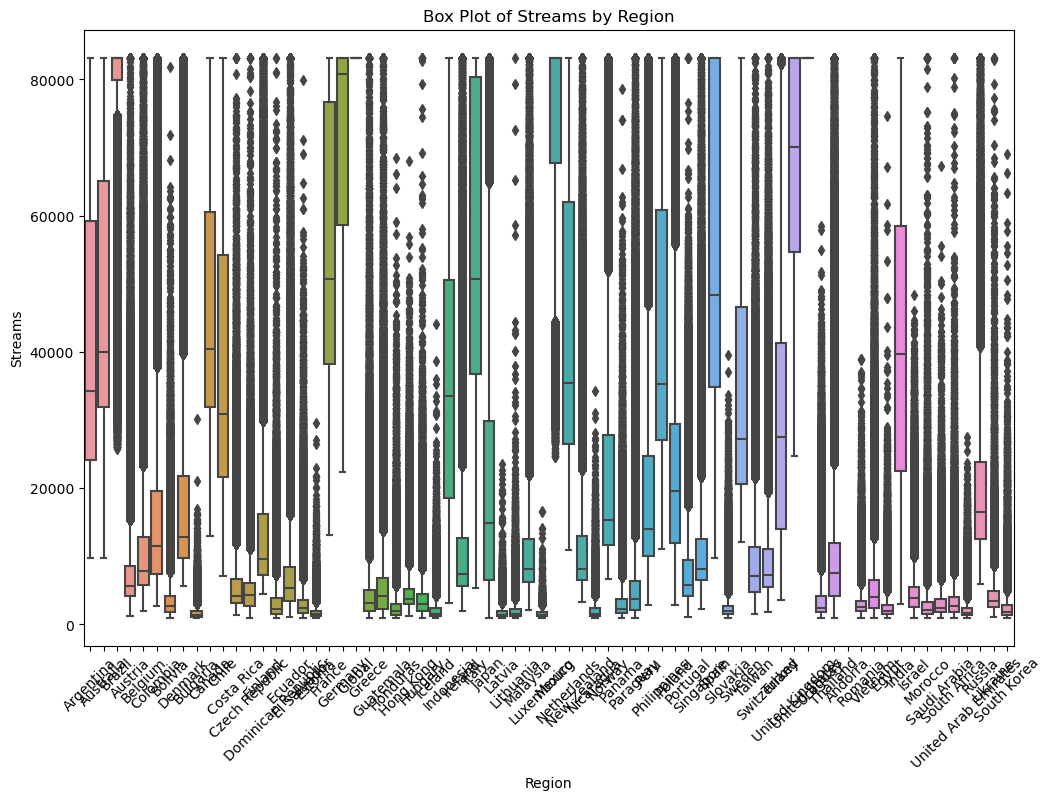

In [73]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='region', y='streams', data=df)
plt.title('Box Plot of Streams by Region')
plt.xlabel('Region')
plt.ylabel('Streams')
plt.xticks(rotation=45)
plt.show()

C:\Users\LTC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


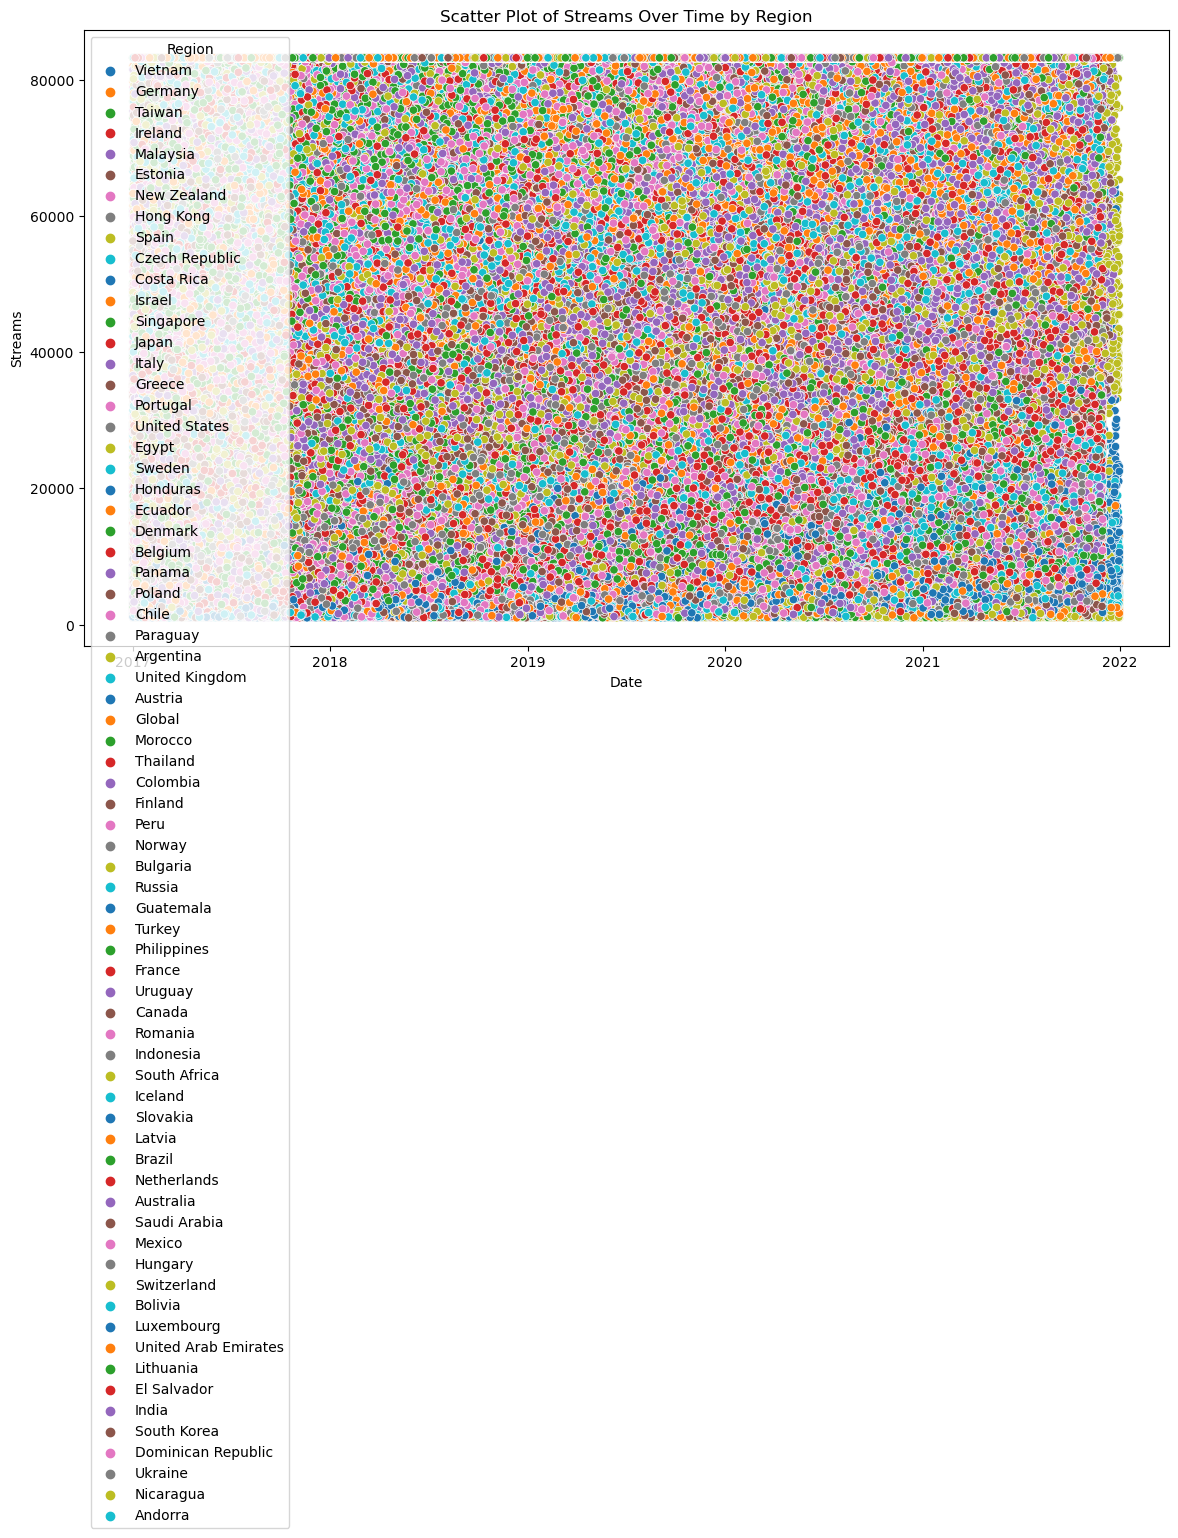

In [74]:
sample_df = df.sample(frac=0.1)

# Scatter plot of 'streams' over 'date'
plt.figure(figsize=(14, 8))
sns.scatterplot(x='date', y='streams', data=sample_df, hue='region', palette='tab10')
plt.title('Scatter Plot of Streams Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Streams')
plt.legend(title='Region')
plt.show()

C:\Users\LTC\AppData\Local\Temp\ipykernel_7632\427364320.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix  = df.corr()


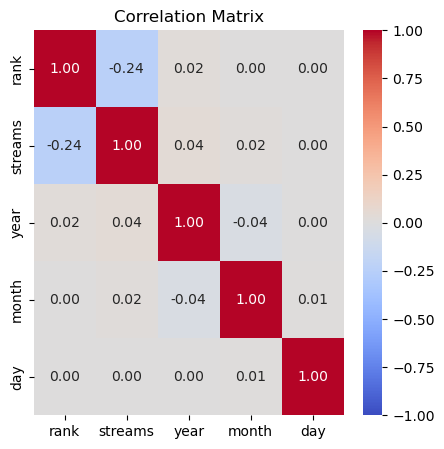

In [98]:
plt.figure(figsize=(5, 5))
correlation_matrix  = df.corr()
sns.heatmap(correlation_matrix , annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

result:There is a weak negative correlation (-0.24) between rank and streams. This means that there is a slight tendency for items with a higher rank to have fewer streams.

There is a weak positive correlation (0.02) between rank and year. This means there may be a slight tendency for items with a higher rank to be more recent.

There is a moderate positive correlation (0.75) between streams and day. This means that there is a tendency for there to be more streams on some days of the week than others.

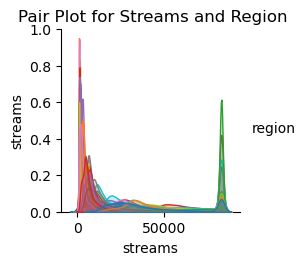

In [77]:
# Pairplot for numerical variables
sns.pairplot(df, vars=['streams'], hue='region', palette='tab10')
plt.suptitle('Pair Plot for Streams and Region', y=1.02)
plt.show()


Result:There does not appear to be a strong correlation between streams and region.
There is a cluster of data points in the bottom left corner of plot in the upper right corner. This suggests that there may be some regions that have very few streams.

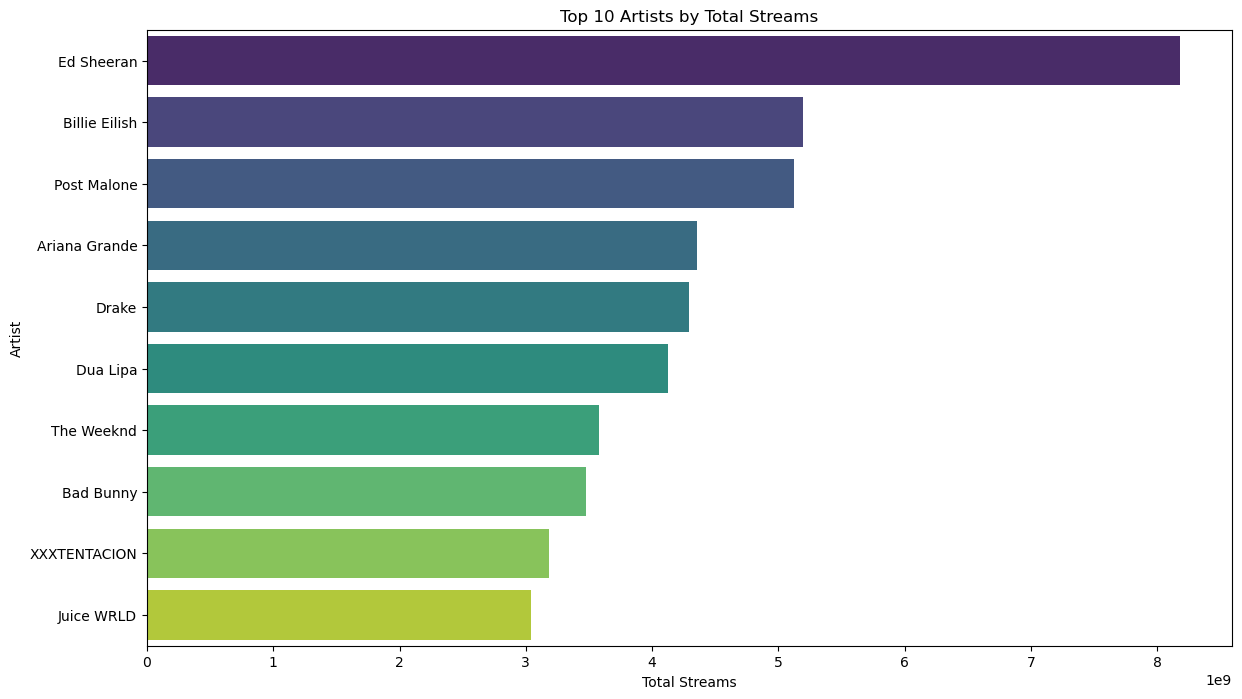

In [78]:
# Bar plot for top 10 artists by total streams
top_artists = df.groupby('artist')['streams'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 8))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Artists by Total Streams')
plt.xlabel('Total Streams')
plt.ylabel('Artist')
plt.show()


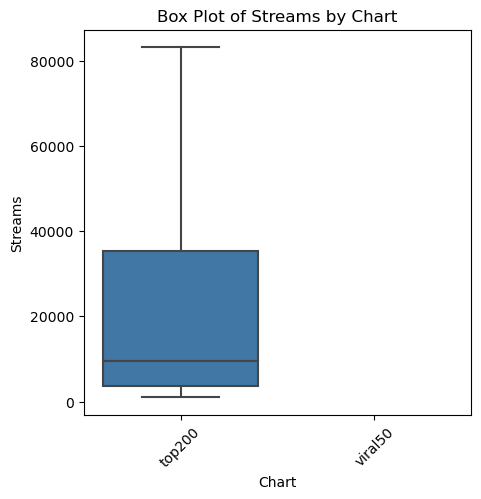

In [99]:
# Box plot for 'streams' by 'chart'
plt.figure(figsize=(5, 5))
sns.boxplot(x='chart', y='streams', data=df)
plt.title('Box Plot of Streams by Chart')
plt.xlabel('Chart')
plt.ylabel('Streams')
plt.xticks(rotation=45)
plt.show()

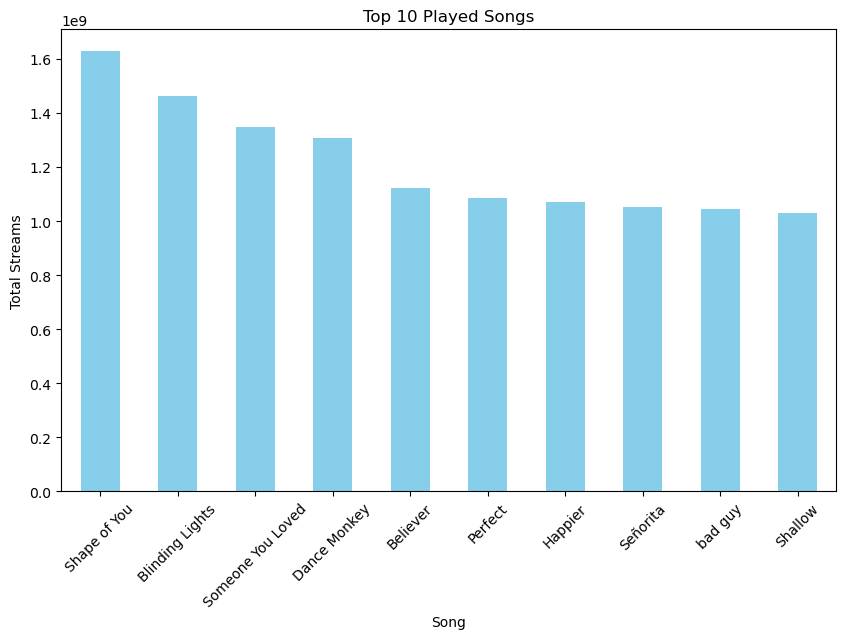

In [84]:
# Calculate the total streams for each song
top_songs = df.groupby('title')['streams'].sum().sort_values(ascending=False).head(10)

# Plot the top played songs using a bar plot
plt.figure(figsize=(10, 6))
top_songs.plot(kind='bar', color='skyblue')
plt.title('Top 10 Played Songs')
plt.xlabel('Song')
plt.ylabel('Total Streams')
plt.xticks(rotation=45)
plt.show()

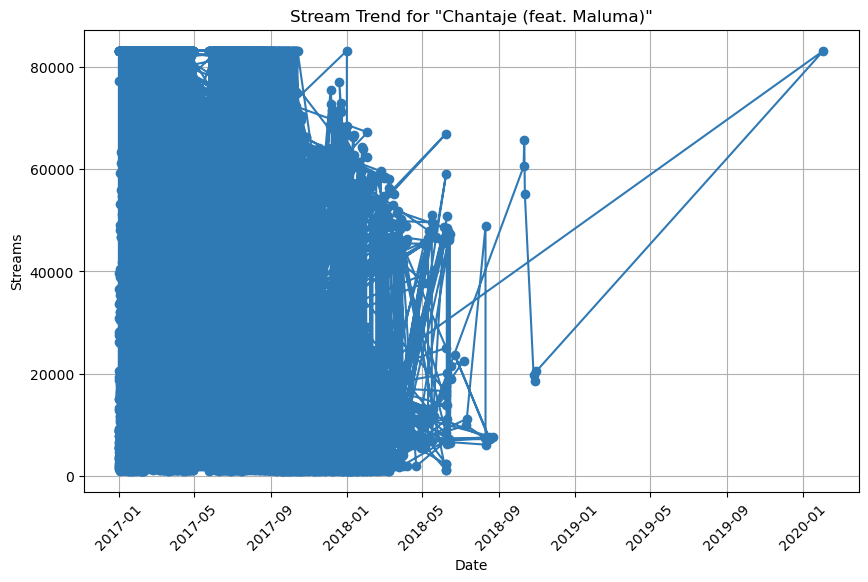

In [100]:
# Assuming you have a time series dataset with columns 'date' and 'streams' for each song
# Let's plot the stream trend for a specific song
specific_song = 'Chantaje (feat. Maluma)'

# Filter the dataset for the specific song
specific_song_data = df[df['title'] == specific_song]

# Plot the stream trend using a line plot
plt.figure(figsize=(10, 6))
plt.plot(specific_song_data['date'], specific_song_data['streams'], marker='o', linestyle='-')
plt.title(f'Stream Trend for "{specific_song}"')
plt.xlabel('Date')
plt.ylabel('Streams')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Result:The median number of streams is higher in "top200" than "viral50". The box for "top200" is shifted up on the y-axis compared to the box for "viral50".
The spread of the data (IQR) is larger for "top200" than "viral50". The box for "top200" is taller than the box for "viral50".
There are outliers in both charts. There are data points for both charts that fall outside the whiskers.